In [327]:
import pandas as pd
import numpy as np
import pickle as pkl
import random
import time
import math
import pybaseball
import sklearn
import itertools
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.base import clone
from sklearn.preprocessing import MultiLabelBinarizer, OrdinalEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, cross_validate, cross_val_predict, GridSearchCV
import matplotlib.pyplot as plt
from pybaseball import playerid_lookup, playerid_reverse_lookup
import warnings
import matplotlib.pyplot as plt
from IPython.display import clear_output

#from ipynb.fs.full.Building_Dataset_Functions import * 

hand_combos = ["RR", "RL", "LR", "LL"]
training_years = ["2012", "2013", "2014"]

plays = ["out", "strikeout", "walk", "single", "double", "triple", "home_run"]

warnings.simplefilter("ignore")

### Odds Functions

In [328]:
def log5 (pB, pP, pL):
    """ Given the probability of a PA outcome for the pitcher, the batter, and the overall league, calculate the
    probability in that given at bat using the log5 equation. NOTE: DO NOT USE RIGHT NOW""" 
    one = (pB*pP)/pL
    two = ((1-pB)*(1-pP))/(1-pL)
    
    return one/(one + two)


def morey_z(pB, pP, pL):
    """ Given the probability of a PA outcome for the pitcher, the batter, and the overall league, calculate the
    probability in that given at bat using the Morey Z equation"""
    one = (pB-pL)/np.sqrt(pL*(1-pL))
    two = (pP-pL)/np.sqrt(pL*(1-pL))
    three = np.sqrt(pL*(1-pL))
    return ((one + two)/np.sqrt(2) * three) +pL

def ab_play_percentages(batting_percentages, pitching_percentages, league_percentages, pitbat_combo, function):
    """ Given a list of probabilities for all PA outcomes for the batter, the pitcher, and the league, along with
    the pitbat combo, and the desired probability funtion, return a list of the probabilities for all PA outcomes 
    for the specific PA"""
    
    ab_percentages = {}
    
    # Get the specific percentages for each play type
    for play in plays:
        batting_percent = batting_percentages["b_" + play]
        pitching_percent = pitching_percentages["p_" + play]
        league_percent = league_percentages[pitbat_combo][play]
        
        # Ensure we are using one of the two acceptable prediction functions
        if function not in ["morey z", "Morey Z", "log5", "Log5"]:
            while funtion not in ["morey z", "Morey Z", "log5", "Log5"]:
                function = input("Acceptable Functions are Morey Z and Log5. Please input one.")
        
        # Calculate the predicted percentage for the specific play for the PA
        if function == "morey z" or function == "Morey Z":
            expected_percent = max(morey_z(batting_percent, pitching_percent, league_percent), 0.000001)
        else:
            expected_percent = log5(batting_percent, pitching_percent, league_percent)
    
        # Insert the predicted percentage for the play type into our dictionary for delivery
        ab_percentages[play] = expected_percent
        
        # Get rid of negative and zero numbers and repercenage slightly if numbers are reset
        ab_percentages = {key: value/sum(list(ab_percentages.values())) for key, value in ab_percentages.items()}
    
    return ab_percentages

# League Average Guesser
def average_guesser(batting_percentages, pitching_percentages, league_percentages, pitbat_combo):
    ab_percentages = {}
    
    for play in plays:
        league_percent = league_percentages[pitbat_combo][play]
        ab_percentages[play] = league_percent
        
    ab_percentages = {key: value/sum(list(ab_percentages.values())) for key, value in ab_percentages.items()}
    
    return ab_percentages  
        

In [329]:
def log_loss(probabilities, actuals):
    """ Given a list of probabilities and acuals for a series of instances, calculate and return the average log loss"""
    log_loss = 0
    yhat_probabilities = []
    for instance in range(len(probabilities)):
        yhat_probabilities.append(max([n for n in np.array(probabilities.iloc[instance])*np.array(actuals.iloc[instance])]))
    log_loss -= sum([np.log10(x)for x in yhat_probabilities])


    return log_loss/len(probabilities)

In [354]:
odds_dataset = pkl.load(open("odds_functions_data_set", "rb"))
odds_dataset = pkl.load(open("odds_functions_dataset_without_yearbreaks.pkl", "rb"))["batting_stats"]

league_averages = pkl.load(open("league_averages.pkl", "rb"))

FileNotFoundError: [Errno 2] No such file or directory: 'odds_functions_data_set'

## Make Odds Predictions on Neutral Training Data

In [23]:
odds_dataset["morey_prediction"] = odds_dataset.apply(lambda x: ab_play_percentages(x[["b_" + play for play in plays]], x[["p_" + play for play in plays]], league_averages, x.pitbat, "morey z"), axis = 1)
odds_dataset["morey_prediction_list"] = odds_dataset.morey_prediction.apply(lambda x: list(x.values()))

odds_dataset["la_prediction"] = odds_dataset.apply(lambda x: average_guesser(x[["b_" + play for play in plays]], x[["p_" + play for play in plays]], league_averages, x.pitbat), axis = 1)
odds_dataset["la_prediction_list"] = odds_dataset.la_prediction.apply(lambda x: list(x.values()))

odds_dataset["actuals"] = odds_dataset.apply(lambda x: list(x.la_prediction.keys()).index(x.play),axis=1)

odds_dataset['yhat'] = odds_dataset.actuals.apply(lambda x: [0]*len(plays))
odds_dataset['yhat'] = odds_dataset.apply(lambda x: x.yhat[0:x.actuals] +[1] +  x.yhat[x.actuals+1:], axis=1)

odds_dataset = odds_dataset.drop(columns = ["morey_prediction", "la_prediction"])

# Remove some instances with NA from pitchers who only make 1 app
odds_dataset.dropna(inplace=True)

In [24]:
crappy_log_loss = log_loss(odds_dataset.la_prediction_list, odds_dataset.yhat)
morey_log_loss = log_loss(odds_dataset.morey_prediction_list, odds_dataset.yhat)

print("Crappy Log Loss: {}".format(crappy_log_loss))
print("Morey Log Loss: {}".format(morey_log_loss))

Crappy Log Loss: 0.6243287896373452
Morey Log Loss: 0.6917390575292162


In [25]:
for play in plays:
    df = odds_dataset[odds_dataset.play == play].copy()
    play_percent = len(df)/len(odds_dataset)
    
    crappy_predictions = log_loss(df.la_prediction_list, df.yhat)
    morey_predictions = log_loss(df.morey_prediction_list, df.yhat)
    
    print(str(play) + "'s average value is {}".format(play_percent))
    print(str(play) + "'s crappy average prediction value is: {}".format(sum(crappy_predictions)/len(crappy_predictions)))
    print(str(play) + "'s morey average prediction value is: {}".format(sum(morey_predictions)/len(morey_predictions)))
    print("\n")

out's average value is 0.4821648345592577


TypeError: 'numpy.float64' object is not iterable

# ML Algorithms

In [355]:
X = pkl.load(open("ML X Dataset", "rb"))
Y_play = pkl.load(open("ML Y Dataset (Plays)", "rb"))
Y_onbase = pkl.load(open("ML Y Dataset (On Base)", "rb"))



In [356]:
# x_train, x_test, y_train, y_test = train_test_split(ml_full_df, y_full, test_size=0.2, random_state=42)
sss = StratifiedShuffleSplit(test_size=.2, random_state=42)
for train_index, test_index in sss.split(X, Y_play):
    x_train, x_test = X[train_index], X[test_index]
    y_train_plays, y_test_plays = Y_play[train_index], Y_play[test_index]
    y_train_onbase, y_test_onbase = Y_onbase[train_index], Y_onbase[test_index]
    
    

## Crappy Average Estimator

In [357]:
dumb_log_loss_plays = 0
league_averages_plays = {}
for play in y_train_plays.value_counts().index:
    league_averages_plays[play] = len(y_train_plays[y_train_plays == play])/len(y_train_plays)
    dumb_log_loss_plays += len(y_train_plays[y_train_plays == play])/len(y_train_plays)* np.log(len(y_train_plays[y_train_plays == play])/len(y_train_plays))
    
    
dumb_log_loss_onbase = 0
league_averages_onbase = {}
for play in y_train_onbase.value_counts().index:
    league_averages_onbase[play] = len(y_train_onbase[y_train_onbase == play])/len(y_train_onbase)
    dumb_log_loss_onbase += len(y_train_onbase[y_train_onbase == play])/len(y_train_onbase)* np.log(len(y_train_onbase[y_train_onbase == play])/len(y_train_onbase))
    
print("The Crappy Average Estimator for Predicting Plays Has a Neg Log Loss of: {}".format(round(dumb_log_loss_plays,3)))
print("The Crappy Average Estimator for Predicting On Base Has a Neg Log Loss of: {}".format(round(dumb_log_loss_onbase,3)))

The Crappy Average Estimator for Predicting Plays Has a Neg Log Loss of: -1.745
The Crappy Average Estimator for Predicting On Base Has a Neg Log Loss of: -0.619


In [353]:
x_train.shape

(6503, 124)

## Regressions

### Basic Logistic Regresssion

In [358]:
softmax_plays = LogisticRegression(class_weight = None, max_iter=150)
softmax_plays_scores = cross_val_score(softmax_plays, x_train, y_train_plays, cv=5, scoring = "neg_log_loss", n_jobs=4)
print("The Basic Logistic Regressor (Plays) Has a Neg Log Loss of: {}".format(round(softmax_plays_scores.mean(),3)))


softmax_onbase = LogisticRegression(max_iter=150)
softmax_onbase_scores = cross_val_score(softmax_onbase, x_train, y_train_onbase, cv=5, scoring = "neg_log_loss", n_jobs=4)
print("The Basic Logistic Regressor (On Base) Has a Neg Log Loss of: {}".format(round(softmax_onbase_scores.mean(),3)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

The Basic Logistic Regressor (Plays) Has a Neg Log Loss of: -1.621
The Basic Logistic Regressor (On Base) Has a Neg Log Loss of: -0.616


### Grid Search Logistic Regression

In [5]:
# Build a Dictionary of class weights to grid search on due to impalanced Dataset
class_weights = list(y_train.value_counts().index)
class_weights_list = []

for n in range(1):
    weights = np.random.rand(len(class_weights))
    weights = weights/sum(weights)
    weights = {class_weights[x]:weights[x] for x in range(len(class_weights))}
    
    class_weights_list.append(weights)
    
class_weights_list.append(None)

In [6]:
parameters = {'C':np.linspace(0.001,1,2), "solver":["newton-cg"], "class_weight":class_weights_list,
              'multi_class':["ovr"]}

grid_search = GridSearchCV(LogisticRegression(), parameters, cv=5, scoring = "neg_log_loss", verbose = 3, n_jobs = 4)
grid_search.fit(x_train, y_train)
clear_output(wait=False)

In [7]:
final_logistic_regressor = grid_search.best_estimator_
print("The Best Logistic Regressor Has a Neg Log Loss Of: {}".format(round(grid_search.best_score_.mean(), 3)))
print("The Best Logistic Regressor Has Parameters Of: {}".format(grid_search.best_params_))

The Best Logistic Regressor Has a Neg Log Loss Of: -1.414
The Best Logistic Regressor Has Parameters Of: {'C': 1.0, 'class_weight': None, 'multi_class': 'ovr', 'solver': 'newton-cg'}


## K Neighbors Classifier

### Basic K Neighbors Classifier

In [291]:
knc_plays = KNeighborsClassifier()
knc_scores_plays = cross_val_score(knc_plays, x_train, y_train_plays, cv=5, scoring = "neg_log_loss", n_jobs=1)
print("The Basic kNeighbors Classifier (Plays) Has a Neg Log Loss of: {}".format(round(knc_scores_plays.mean(),3)))

knc_onbase = KNeighborsClassifier()
knc_scores_onbase = cross_val_score(knc_onbase, x_train, y_train_onbase, cv=5, scoring = "neg_log_loss", n_jobs=1)
print("The Basic kNeighbors Classifier (On Base) Has a Neg Log Loss of: {}".format(round(knc_scores_onbase.mean(),3)))

The Basic kNeighbors Classifier (Plays) Has a Neg Log Loss of: -9.628
The Basic kNeighbors Classifier (On Base) Has a Neg Log Loss of: -2.254


### Grid Search K Neighbors Classifier

In [292]:
# Detail parameters for the K Neighbors Grid Search Below
n_neighbors_params = [1000]
weights_params = ["uniform"]

In [293]:
knc_parameters = {'n_neighbors':n_neighbors_params, "weights":weights_params}

print("Grid Search For Plays")
knc_grid_search_plays = GridSearchCV(KNeighborsClassifier(), knc_parameters, cv=5, scoring = "neg_log_loss", verbose = 3)
knc_grid_search_plays.fit(x_train, y_train_plays)
clear_output(wait=False)

print("Grid Search For On Base")
knc_grid_search_onbase = GridSearchCV(KNeighborsClassifier(), knc_parameters, cv=5, scoring = "neg_log_loss", verbose = 3)
knc_grid_search_onbase.fit(x_train, y_train_onbase)
clear_output(wait=False)

Grid Search For Plays
Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

In [215]:
final_KNC_regressor_plays = knc_grid_search_plays.best_estimator_
print("The Best K Neighbors Classifier Has a Neg Log Loss Of: {}".format(round(knc_grid_search_plays.best_score_.mean(), 3)))
print("The Best K Neighbors Classifier Has Parameters Of: {}".format(knc_grid_search_plays.best_params_))

final_KNC_regressor_onbase = knc_grid_search_onbase.best_estimator_
print("The Best K Neighbors Classifier Has a Neg Log Loss Of: {}".format(round(knc_grid_search_onbase.best_score_.mean(), 3)))
print("The Best K Neighbors Classifier Has Parameters Of: {}".format(knc_grid_search_onbase.best_params_))

The Best K Neighbors Classifier Has a Neg Log Loss Of: -1.419
The Best K Neighbors Classifier Has Parameters Of: {'n_neighbors': 1000, 'weights': 'uniform'}
The Best K Neighbors Classifier Has a Neg Log Loss Of: -0.626
The Best K Neighbors Classifier Has Parameters Of: {'n_neighbors': 1000, 'weights': 'uniform'}


## Random Forest Classifier

### Basic Random Forest Classifier

In [216]:
rf_plays = RandomForestClassifier(random_state=42)
rf_scores_plays = cross_val_score(rf_plays, x_train, y_train_plays, cv = 5, scoring = "neg_log_loss")
print("The Basic Random Forest Classifier (Plays) Has a Neg Log Loss of: {}".format(round(rf_scores_plays.mean(),3)))

rf_onbase = RandomForestClassifier(random_state=42)
rf_scores_onbase = cross_val_score(rf_onbase, x_train, y_train_onbase, cv = 5, scoring = "neg_log_loss")
print("The Basic Random Forest Classifier (On Base) Has a Neg Log Loss of: {}".format(round(rf_scores_onbase.mean(),3)))

The Basic Random Forest Classifier (Plays) Has a Neg Log Loss of: -2.633
The Basic Random Forest Classifier (On Base) Has a Neg Log Loss of: -0.805


### Grid Search for Random Forest Classifier

In [217]:
# Detail parameters for the Random Forest Grid Search Below
estimators_params= [900, 1100, 1300]
criterion_params = ["gini", "entropy", "log_loss"]
max_depth_params = [3, 4, 5]

In [218]:
rf_parameters = {'n_estimators':estimators_params, "criterion":criterion_params, "max_depth":max_depth_params}

print("Grid Search For Plays")
rf_grid_search_plays = GridSearchCV(RandomForestClassifier(random_state = 42), rf_parameters, cv=5, scoring = "neg_log_loss", verbose = 3)
rf_grid_search_plays.fit(x_train[:10000], y_train_plays[:10000])
clear_output(wait=False)

print("Grid Search For On Base")
rf_grid_search_onbase = GridSearchCV(RandomForestClassifier(random_state = 42), rf_parameters, cv=5, scoring = "neg_log_loss", verbose = 3)
rf_grid_search_onbase.fit(x_train[:10000], y_train_onbase[:10000])
clear_output(wait=False)

In [219]:
final_RF_regressor_plays = rf_grid_search_plays.best_estimator_
print("The Best Random Forest Classifier (Plays) Has a Neg Log Loss Of: {}".format(round(rf_grid_search_plays.best_score_.mean(), 3)))
print("The Best Random Forest Classifier (On Base) Has Parameters Of: {}".format(rf_grid_search_plays.best_params_))

final_RF_regressor_onbase = rf_grid_search_onbase.best_estimator_
print("The Best Random Forest Classifier (Plays) Has a Neg Log Loss Of: {}".format(round(rf_grid_search_onbase.best_score_.mean(), 3)))
print("The Best Random Forest Classifier (On Base) Has Parameters Of: {}".format(rf_grid_search_onbase.best_params_))

The Best Random Forest Classifier (Plays) Has a Neg Log Loss Of: -1.426
The Best Random Forest Classifier (On Base) Has Parameters Of: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 1100}
The Best Random Forest Classifier (Plays) Has a Neg Log Loss Of: -0.631
The Best Random Forest Classifier (On Base) Has Parameters Of: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 900}


## SVC

### Basic Support Vector Classifier

In [340]:
svc_plays = SVC(probability=True)
svc_scores_plays = cross_val_score(svc_plays, x_train, y_train_plays, cv = 5, scoring = "neg_log_loss")
print("The Basic Support Vector Classifier (Plays) Has a Neg Log Loss of: {}".format(round(svc_scores_plays.mean(),3)))

svc_onbase = SVC(probability=True)
svc_scores_onbase = cross_val_score(svc_onbase, x_train, y_train_onbase, cv = 5, scoring = "neg_log_loss")
print("The Basic Support Vector Classifier (On Base) Has a Neg Log Loss of: {}".format(round(svc_scores_onbase.mean(),3)))

The Basic Support Vector Classifier (Plays) Has a Neg Log Loss of: -1.723
The Basic Support Vector Classifier (On Base) Has a Neg Log Loss of: -0.61


### Grid Search for Support Vector Classifier

In [224]:
# Detail parameters for the Support Vector Classifier Grid Search Below
C_params= [.33,.66, 1]
kernel_params = ["linear", "poly", "rbf", "sigmoid"]
degree_params = [3,5,7]
gamma_params = ["auto", "scale"]
class_weight_params = [None, "balanced"]

Because SVCs scale poorly with n instances, we can try training the model on a subset of the training data. The below cells first find a suitible SVC to test on the subsample, and then cross_val_score and increasing sizes of the sample to check where the cross-entropy levels out

In [225]:
# Run a Grid Search for our SVC on a 5000 instance subset of the training data
svc_parameters = {'C':C_params, "kernel":kernel_params, "degree":degree_params, "gamma":gamma_params, "class_weight":class_weight_params}

print("Grid Search For Plays")
svc_grid_search_plays = GridSearchCV(SVC(probability=True), svc_parameters, cv=5, scoring = "neg_log_loss", verbose = 5)
svc_grid_search_plays.fit(x_train[:5000], y_train_plays[:5000])
clear_output(wait=False)

print("Grid Search For On Base")
svc_grid_search_onbase = GridSearchCV(SVC(probability=True), svc_parameters, cv=5, scoring = "neg_log_loss", verbose = 5)
svc_grid_search_onbase.fit(x_train[:5000], y_train_onbase[:5000])
clear_output(wait=False)

Grid Search For Plays
Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END C=0.33, class_weight=None, degree=3, gamma=auto, kernel=linear;, score=-1.448 total time=   4.1s
[CV 2/5] END C=0.33, class_weight=None, degree=3, gamma=auto, kernel=linear;, score=-1.449 total time=   3.9s



KeyboardInterrupt



In [ ]:
final_SVC_regressor_plays = svc_grid_search_plays.best_estimator_
print("The Best Support Vector Classifier (Plays) Has a Neg Log Loss Of: {}".format(round(svc_grid_search_plays.best_score_.mean(), 3)))
print("The Best Support Vector Classifier (Plays) Has Parameters Of: {}".format(svc_grid_search.best_params_))

final_SVC_regressor_onbase = svc_grid_search_onbase.best_estimator_
print("The Best Support Vector Classifier (On Base) Has a Neg Log Loss Of: {}".format(round(svc_grid_search_onbase.best_score_.mean(), 3)))
print("The Best Support Vector Classifier (On Base) Has Parameters Of: {}".format(svc_grid_search_onbase.best_params_))

In [45]:
#score_dict_II = {}
for n in [15000]:
    print(n)
    model = SVC(C=.33, class_weight="balanced", degree=7, gamma="auto", kernel="rbf", probability=True)
    score = cross_val_score(model, x_train[:n], y_train[:n], cv=5, scoring="neg_log_loss", verbose=3, error_score="raise", n_jobs=4)
    score_dict_II[n] = -score.mean()
    clear_output(wait=False)

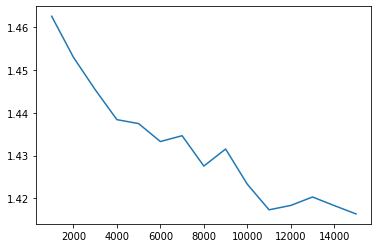

In [46]:
plt.plot(score_dict_II.keys(), score_dict_II.values())
plt.title("SVC Log Loss With Sample Size n")

## Gradient Boosting Classifier

Similar to the SVC, we will attempt to find a suitable model on a smaller sample of the data, although we can train the final model on the full dataset

### Basic Gradient Boosting Classifier

In [226]:
gbc_plays = GradientBoostingClassifier()
gbc_scores_plays = cross_val_score(gbc_plays, x_train[:5000], y_train_plays[:5000], cv=5, scoring="neg_log_loss", verbose=3, n_jobs=4)
print("The Basic Gradient Boosted Classifier (Plays) Has a Neg Log Loss of: {}".format(round(gbc_scores_plays.mean(),3)))

gbc_onbase = GradientBoostingClassifier()
gbc_scores_onbase = cross_val_score(gbc_onbase, x_train[:5000], y_train_onbase[:5000], cv=5, scoring="neg_log_loss", verbose=3, n_jobs=4)
print("The Basic Gradient Boosted Classifier (On Base) Has a Neg Log Loss of: {}".format(round(gbc_scores_onbase.mean(),3)))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   12.4s remaining:   18.6s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   22.3s finished


The Basic Gradient Boosted Classifier (Plays) Has a Neg Log Loss of: -1.53


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.2s


The Basic Gradient Boosted Classifier (On Base) Has a Neg Log Loss of: -0.647


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.5s finished


### Grid Search for Gradient Boosting Classifier

In [8]:
estimator_params = [100, 200, 300]
depth_params = [2, 3, 4]

In [9]:
gbc_parameters = {'n_estimators':estimator_params, "max_depth":depth_params}

print("Grid Search For Plays")
gbc_grid_search_plays = GridSearchCV(GradientBoostingClassifier(), gbc_parameters, cv=5, scoring = "neg_log_loss", verbose = 3, n_jobs=4)
gbc_grid_search_plays.fit(x_train[:5000], y_train_plays[:5000])
clear_output(wait=False)

print("Grid Search For On Base")
gbc_grid_search_onbase = GridSearchCV(GradientBoostingClassifier(), gbc_parameters, cv=5, scoring = "neg_log_loss", verbose = 3, n_jobs=4)
gbc_grid_search_onbase.fit(x_train[:5000], y_train_onbase[:5000])
clear_output(wait=False)

In [10]:
final_GBC_regressor_plays = gbc_grid_search.best_estimator_
print("The Best Gradient Boosted Classifier (Plays) Has a Neg Log Loss Of: {}".format(round(gbc_grid_search_plays.best_score_.mean(), 3)))
print("The Best Gradient Boosted Classifier (Plays Has Parameters Of: {}".format(gbc_grid_search_plays.best_params_))

final_GBC_regressor_onbase = gbc_grid_search.best_estimator_
print("The Best Gradient Boosted Classifier (On Base) Has a Neg Log Loss Of: {}".format(round(gbc_grid_search_onbase.best_score_.mean(), 3)))
print("The Best Gradient Boosted Classifier (On Base) Has Parameters Of: {}".format(gbc_grid_search_onbase.best_params_))

The Best Gradient Boosted Classifier Has a Neg Log Loss Of: -1.481
The Best Gradient Boosted Classifier Has Parameters Of: {'max_depth': 2, 'n_estimators': 100}


#### Histogram Based Option

Because of the testing limitations, we will also try a Histogram-based Gradient Boosting Classification Tree, which scales significantly better than the standard gradient boosting tree. It does not appear to support grid search however, so we will do that manually

In [359]:
hgbc_plays = HistGradientBoostingClassifier()
hgbc_scores_plays = cross_val_score(hgbc_plays, x_train, y_train_plays, cv=5, scoring="neg_log_loss", n_jobs = 4)
print("The Basic Hist Gradient Boosted Classifier (Plays) Has a Neg Log Loss of: {}".format(round(hgbc_scores_plays.mean(),3)))

hgbc_onbase = HistGradientBoostingClassifier()
hgbc_scores_onbase = cross_val_score(hgbc_onbase, x_train, y_train_onbase, cv=5, scoring="neg_log_loss", n_jobs = 4)
print("The Basic Hist Gradient Boosted Classifier (On Base) Has a Neg Log Loss of: {}".format(round(hgbc_scores_onbase.mean(),3)))

The Basic Hist Gradient Boosted Classifier (Plays) Has a Neg Log Loss of: -1.62
The Basic Hist Gradient Boosted Classifier (On Base) Has a Neg Log Loss of: -0.615


In [310]:
iter_params = [30, 50, 70]
depth_params = [5, 10, None]
max_leaf_params = [2, 3, None]

all_param_lists = [iter_params, depth_params, max_leaf_params]

hgbc_param_list = list(itertools.product(*all_param_lists))

In [311]:
# Grid Search for the Plays Model
print("Grid Search For Plays")

best_score_plays = -10000
best_params_plays = {}
for tup in hgbc_param_list:
    print(tup)
    score = cross_val_score(HistGradientBoostingClassifier(max_iter=tup[0], max_depth = tup[1], max_leaf_nodes = tup[2]), x_train, y_train_plays, cv=5,
                                                          n_jobs = 4, scoring="neg_log_loss").mean()
    
    if score > best_score_plays:
        best_score_plays = score
        best_params_plays = {"max_iter":tup[0], "max_depth":tup[1], "max_leaf_nodes":tup[2],}
                            
    clear_output(wait=False)
    
# And Grid Search Again for the On Base Model
print("Grid Search For On Base")

best_score_onbase = -10000
best_params_onbase = {}
for tup in hgbc_param_list:
    print(tup)
    score = cross_val_score(HistGradientBoostingClassifier(max_iter=tup[0], max_depth = tup[1], max_leaf_nodes = tup[2]), x_train, y_train_onbase, cv=5,
                                                          n_jobs = 4, scoring="neg_log_loss").mean()
    
    if score > best_score_onbase:
        best_score_onbase = score
        best_params_onbase = {"max_iter":tup[0], "max_depth":tup[1], "max_leaf_nodes":tup[2],}
                            
    clear_output(wait=False)

(50, None, None)



KeyboardInterrupt



In [ ]:
final_HGBC_regressor_plays = HistGradientBoostingClassifier(max_iter=best_params_plays["max_iter"], max_depth = best_params_plays["max_depth"], max_leaf_nodes = best_params_plays["max_leaf_nodes"])
print("The Best Histogram-Based Gradient Boosted Classifier (Plays) Has a Neg Log Loss Of: {}".format(round(best_score_plays, 3)))
print("The Best Histogram-Based Gradient Boosted Classifier (Plays) Has Parameters Of: {}".format(best_params_plays))

final_HGBC_regressor_onbase = HistGradientBoostingClassifier(max_iter=best_params_onbase["max_iter"], max_depth = best_params_onbase["max_depth"], max_leaf_nodes = best_params_onbase["max_leaf_nodes"])
print("The Best Histogram-Based Gradient Boosted Classifier (On Base) Has a Neg Log Loss Of: {}".format(round(best_score_onbase, 3)))
print("The Best Histogram-Based Gradient Boosted Classifier (On Base) Has Parameters Of: {}".format(best_params_onbase))

## ADA Boost Classifier

### Basic ADA Boost Classifier

In [58]:
abc = AdaBoostClassifier()
abc_scores = cross_val_score(abc, x_train, y_train, cv=5, scoring="neg_log_loss", n_jobs = 4)
print("The Basic ADA Boost Classifier Has a Neg Log Loss of: {}".format(round(abc_scores.mean(),3)))

The Basic ADA Boost Classifier Has a Neg Log Loss of: -1.919


In [87]:
abc = AdaBoostClassifier(base_estimator = SVC(), algorithm = "SAMME")
abc_scores = cross_val_score(abc, x_train[:2000], y_train[:2000], cv=5, scoring="neg_log_loss", n_jobs = 4, verbose=3)
print("The Basic ADA Boost Classifier Has a Neg Log Loss of: {}".format(round(abc_scores.mean(),3)))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   24.8s remaining:   37.2s


The Basic ADA Boost Classifier Has a Neg Log Loss of: -1.935


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   47.9s finished


### Grid Search for ADA Boost Classifier

In [89]:
estimators_params = [300]

In [90]:
abc_parameters = {'n_estimators':estimators_params}

abc_grid_search = GridSearchCV(AdaBoostClassifier(random_state = 42), abc_parameters, cv=5, scoring = "neg_log_loss", verbose = 3)
abc_grid_search.fit(x_train[:30000], y_train[:30000])
clear_output(wait=False)

In [91]:
final_abc_regressor = abc_grid_search.best_estimator_
print("The Best Ada Boost Classifier Has a Neg Log Loss Of: {}".format(round(abc_grid_search.best_score_, 3)))
print("The Best Ada Boost Classifier Has Parameters Of: {}".format(abc_grid_search.best_params_))

The Best Ada Boost Classifier Has a Neg Log Loss Of: -1.936
The Best Ada Boost Classifier Has Parameters Of: {'n_estimators': 300}
[CV] END .................................. score: (test=nan) total time=   0.0s
[CV] END ............................... score: (test=-1.935) total time=  24.8s
[CV] END .................................. score: (test=nan) total time=   0.0s
[CV] END .................................. score: (test=nan) total time=   0.0s
[CV] END ............................... score: (test=-1.935) total time=  25.4s
[CV] END .................................. score: (test=nan) total time=   0.0s
[CV] END ............................... score: (test=-1.935) total time=  25.4s
[CV] END .................................. score: (test=nan) total time=   0.0s
[CV] END ............................... score: (test=-1.935) total time=  24.4s
[CV] END ............................... score: (test=-1.935) total time=  23.4s


## XGBoost Classifier

In [361]:
y_train_plays_encoded = OrdinalEncoder().fit_transform(np.array(y_train_plays).reshape(-1,1))
y_train_plays_encoded = [int(x[0]) for x in y_train_plays_encoded]

y_train_onbase_encoded = OrdinalEncoder().fit_transform(np.array(y_train_onbase).reshape(-1,1))
y_train_onbase_encoded = [int(x[0]) for x in y_train_onbase_encoded]

### Basic XGBoost Classifier

In [115]:
xgb = XGBClassifier()
xgb_scores = cross_val_score(xgb, x_train, y_train_encoded, cv=5, scoring="neg_log_loss", n_jobs=4, verbose = 3)
print("The Basic XGBoost Boost Classifier Has a Neg Log Loss of: {}".format(round(xgb_scores.mean(),3)))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   18.0s remaining:   26.9s


The Basic XGBoost Boost Classifier Has a Neg Log Loss of: -1.424


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   27.2s finished


### Grid Search for XGBoostClassifier

In [118]:
child_weight_params = [1, 5]
gamma_params = [.5, 1, 1.5]
subsample_params = [.6, .8]
colsample_bytree_params = [.6, .8]
max_depth_params = [2, 3, 4]

In [122]:
xgb_params = {'min_child_weight': child_weight_params,'gamma': gamma_params,'subsample': subsample_params,
              'colsample_bytree': colsample_bytree_params,'max_depth': max_depth_params}

xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_params, cv=5, scoring = "neg_log_loss", verbose = 3)
xgb_grid_search.fit(x_train[:30000], y_train_encoded[:30000])
clear_output(wait=False)

In [123]:
final_xgb_regressor = xgb_grid_search.best_estimator_
print("The Best XGBoost Classifier Has a Neg Log Loss Of: {}".format(round(xgb_grid_search.best_score_, 3)))
print("The Best XABoost Classifier Has Parameters Of: {}".format(xgb_grid_search.best_params_))

The Best Ada Boost Classifier Has a Neg Log Loss Of: -1.423
The Best Ada Boost Classifier Has Parameters Of: {'colsample_bytree': 0.6, 'gamma': 1.5, 'max_depth': 2, 'min_child_weight': 5, 'subsample': 0.8}


In [124]:
scores = cross_val_score(xgb_grid_search.best_estimator_, x_train, y_train_encoded, cv=5, scoring="neg_log_loss", verbose=3, n_jobs=4)
print("The Best XGBoost Classifier Has a Neg Log Loss Of: {}".format(round(scores.mean(), 3)))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   12.3s remaining:   18.4s


The Best XGBoost Classifier Has a Neg Log Loss Of: -1.412


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   18.3s finished


## Neural Network

In [363]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

callback = tf.keras.callbacks.EarlyStopping(monitor='sparse_categorical_crossentropy', patience=5, start_from_epoch=4, restore_best_weights = True)

# Create a Sequential model
model = Sequential()

# Add the first hidden layer with 10 nodes and specify the input shape (54 inputs)
model.add(Dense(10, input_shape=(126,), activation='relu'))

# Add the second hidden layer with 10 nodes
model.add(Dense(10, activation='relu'))

# Add the output layer with 7 nodes (for 7 categorical outputs) and 'softmax' activation
model.add(Dense(13, activation='softmax'))

# Call model on a test input
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_crossentropy'])
# fit the keras model on the dataset
model.fit(x_train, np.array(y_train_plays_encoded), epochs=150, batch_size=10, callbacks = [callback])


Epoch 1/150
36573/36573 [==============================] - 15s 395us/step - loss: 1.6437 - sparse_categorical_crossentropy: 1.6437
Epoch 2/150
36573/36573 [==============================] - 14s 394us/step - loss: 1.6094 - sparse_categorical_crossentropy: 1.6094
Epoch 3/150
36573/36573 [==============================] - 14s 394us/step - loss: 1.6063 - sparse_categorical_crossentropy: 1.6063
Epoch 4/150
36573/36573 [==============================] - 14s 394us/step - loss: 1.6050 - sparse_categorical_crossentropy: 1.6050
Epoch 5/150
36573/36573 [==============================] - 14s 394us/step - loss: 1.6038 - sparse_categorical_crossentropy: 1.6038
Epoch 6/150
36573/36573 [==============================] - 14s 394us/step - loss: 1.6031 - sparse_categorical_crossentropy: 1.6031
Epoch 7/150
36573/36573 [==============================] - 14s 394us/step - loss: 1.6028 - sparse_categorical_crossentropy: 1.6028
Epoch 8/150
36573/36573 [==============================] - 14s 393us/step - loss: 1